In [1]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics
from random import randint
from matplotlib import pyplot as plt


In [3]:
df = pd.read_csv("dataset/Blood_samples_dataset_balanced.csv")
X=df.iloc[:,:-1]
y_str=df.iloc[:,-1]
y_classes = np.unique(y_str)
y=np.zeros_like(y_str,dtype=np.int32)
for i,c in enumerate(y_classes):
    class_indices=y_str==c
    y[class_indices]=i
y

array([2, 1, 3, ..., 0, 1, 0], dtype=int32)

In [27]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor, XGBClassifier

# for high-dimensional data use `gpu` for device if you have one
special_model = XGBClassifier(device='cpu',max_bin=1000)

params = {
    'max_depth':np.arange(1,6),
    'max_leaves':[15,20,25,30,40],
    'n_estimators':[2,5,10,15,20,40],
    'learning_rate':[0.01,0.05,0.1,0.3],
    'subsample':[0.1,0.2,0.5,0.7], 
    'colsample_bytree':[0.1,0.3,0.5,0.8,0.95],
    'min_child_weight': [1,3, 5,7, 10],
    'reg_lambda':[0.4, 0.6, 0.8, 1, 1.2, 1.4],
    'gamma': [0, 0.5, 1, 1.5, 2, 2.5, 5],
}
state = randint(0,100)
search = RandomizedSearchCV(
    special_model,
    params,
    n_iter=500,
    cv=5,
    random_state=state,
    n_jobs=-1,
    # scoring="precision"
)
search.fit(X,y)
special_model=search.best_estimator_

In [39]:
# do repeated stratified k-fold cross-validation with classification report
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedStratifiedKFold

def cross_val_classification_report(model,X,y,n_splits,n_repeats,random_state = 42, target_names = None):
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    y_true = []
    y_pred = []
    for train,test in cv.split(X,y):
        X_train = X[train]
        X_test = X[test]
        y_train = y[train]
        y_test = y[test]
        y_test_pred = model.fit(X_train,y_train).predict(X_test)
        y_true.append(y_test)
        y_pred.append(y_test_pred)

    y_true=np.concatenate(y_true)
    y_pred=np.concatenate(y_pred)

    return classification_report(y_true,y_pred,target_names=target_names)

special_model.device='cpu'
report = cross_val_classification_report(
    model=special_model,
    X=X.to_numpy(),
    y=y,
    n_splits=10,
    n_repeats=3,
    random_state=50,
    target_names=y_classes
)
print(report)

              precision    recall  f1-score   support

      Anemia       1.00      1.00      1.00      1869
    Diabetes       1.00      1.00      1.00      1620
     Healthy       1.00      1.00      1.00      1668
    Thalasse       1.00      1.00      1.00      1527
    Thromboc       1.00      1.00      1.00       369

    accuracy                           1.00      7053
   macro avg       1.00      1.00      1.00      7053
weighted avg       1.00      1.00      1.00      7053



In [29]:
from sklearn.model_selection import cross_val_predict

# scoring = metrics.mean_absolute_error
def run_iteration(X,y,model,pred_scoring,evaluate_scoring,cv=5,repeats=3,seed = 42):
    total_errors = []
    pred_scores = []
    for i in range(repeats):
        shuffle = np.arange(0,len(y))
        np.random.seed(i+seed)
        np.random.shuffle(shuffle)

        pred=cross_val_predict(model,X[shuffle],y[shuffle],cv=cv)
        pred_score = [pred_scoring([a],[b]) for a,b in zip(pred,y)]
        pred_score=np.array(pred_score)
        total_error=evaluate_scoring(pred,y)
        
        inv_shuffle=np.zeros_like(shuffle)
        inv_shuffle[shuffle]=np.arange(len(shuffle))

        total_errors.append(total_error)
        pred_scores.append(pred_score[inv_shuffle])
    
    pred_scores=np.array(pred_scores)
    total_error=np.array(total_error)
    
    return np.mean(pred_scores,axis=0),np.mean(total_errors)

total error  3.0519778817524457


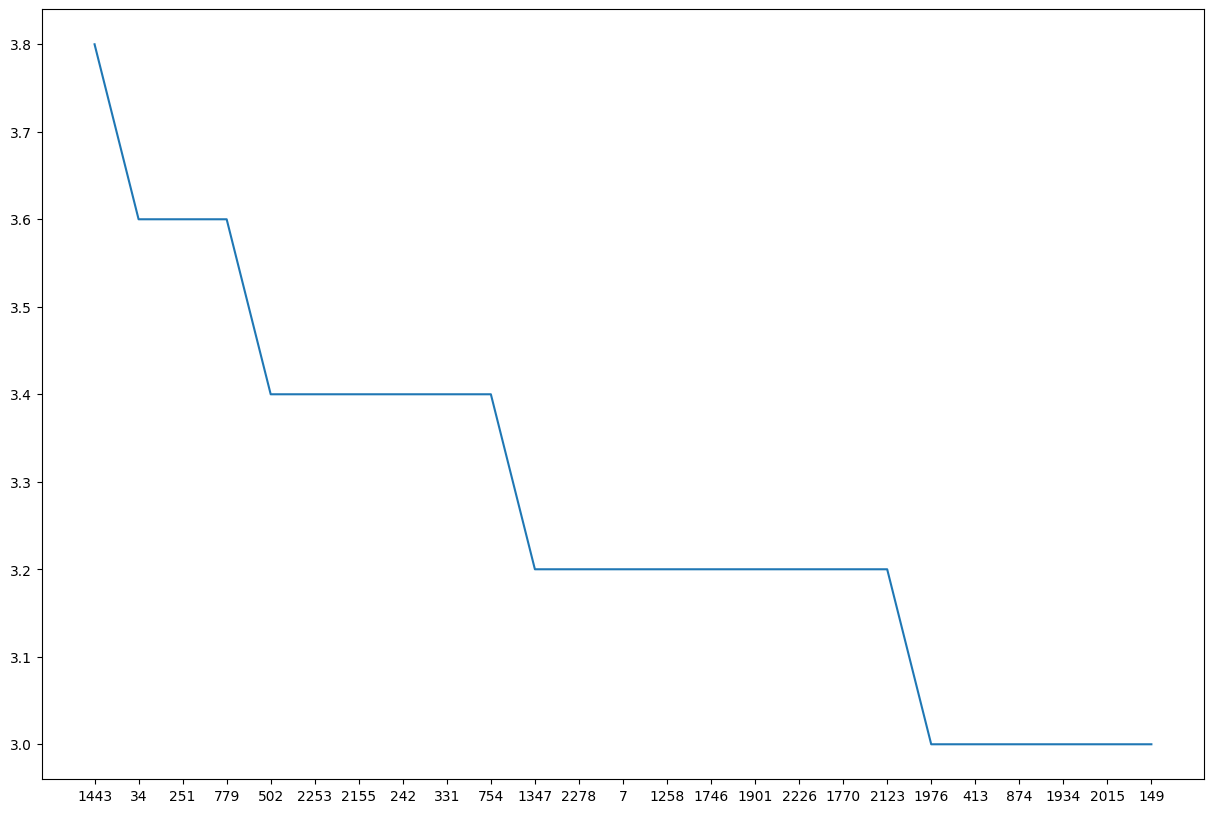

In [32]:
from sklearn.model_selection import RepeatedStratifiedKFold, RepeatedKFold

# indices_to_remove = [381, 1101, 1616, 1625, 2197, 1764,6, 1892, 1229, 1770,715,754,553,629, 614, 1320, 1934,  561,  443,  149, 1775, 1444, 1453, 1219, 1868]
indices_to_remove=[]
X_cleaned = [row for i,row in enumerate(X.to_numpy()) if i not in indices_to_remove]
y_cleaned = [row for i,row in enumerate(y) if i not in indices_to_remove]

X_cleaned=np.array(X_cleaned)
y_cleaned=np.array(y_cleaned)

pred, total = run_iteration(
    X=X_cleaned,
    y=y_cleaned,
    model=special_model,
    pred_scoring=metrics.mean_absolute_error,
    evaluate_scoring=metrics.mean_squared_error,
    cv=10,
    repeats=5,
    seed=randint(0,100))
print("total error ",total)
indices = np.argsort(-pred)
indices=indices[:25]
x=np.arange(0,len(indices))
plt.figure(figsize=(15,10))
plt.plot(x,pred[indices])
plt.xticks(x,labels=indices)
plt.show()